# Introduction to vector and raster analysis


This tutorial goes through a simplified workflow carried out in the [Urban Taxonomy using Hierarchical Morphotope Classification](https://urbantaxonomy.org/) project. The project aims to deliniate areas with similar morphological character - with similar configurations of streets, buildings and the space between them. The similarity reflect the land use use, planning paradigms and conditions under which they were constructed. The project covers every street and building in 6 contiguous European countries, ~120 million data points with 60 features each. This tutorial focuses on a small area, fewer features and simplified analysis to demonstrate the core concepts.

The buildings and street data used in the tutorial, as well as in the paper, comes from Overturemaps, which is a superset of Openstreetmap in which other data is included. 

For a more detailed look into this type work visit the ``momepy`` documentaiton: https://docs.momepy.org/.

Or have a look at the full project page: https://urbantaxonomy.org/ and related GitHub repository: https://github.com/uscuni/urban_taxonomy/.

In [1]:
# import the requried libraries
import geopandas as gpd
import libpysal
import matplotlib.pyplot as plt
import momepy
import neatnet
import numpy as np
import pandas as pd
import shapely
from overturemaps import record_batch_reader

We will focus the analysis on Norwich.

In [2]:
place = "Znojmo, Czechia"
epsg_eu = 3035

In [3]:
centre = gpd.tools.geocode(place)


# hardcode if the geocoding service is down
# centre = gpd.GeoSeries(
#     [shapely.Point(14.35952 49.4503)], name="geometry", crs="epsg:4326"
# )

In [4]:
buffered_centre = centre.to_crs(epsg=epsg_eu).buffer(2_000)

## Buildings

One of the core elements of the analysis are detailed building footprints. To get the data, we first read all the possible information for buildings from Overture maps for our specified location. Since  Overture data is a combination of Openstreetmap buioldings, 3rd-party buildings and satelite derived buildings footprints we will need to carry out some preprocessing to adress data inconsistencies and quality problems.

We are reading a small part of a large file with billions of buildings and streets and other geospatial objects. The file format is `geoparquet` and does not require any additional services to support partial reading of data - no servers, no code. You only need the file and to upload it in a compatible storage engine like S3 or Azure Blob Storage. You can write such files with ```gdf.to_parquet(...)```


In [5]:
reader = record_batch_reader(
    "building", bbox=tuple(buffered_centre.to_crs(epsg=4326).bounds.values[0])
)
res = reader.read_all()
buildings = gpd.GeoDataFrame.from_arrow(res)
buildings = buildings.set_crs(epsg=4326)

Next, we filter out unwated structures.

In [6]:
unwanted = [
    "garage",
    "garages",
    "shed",
    "bungalow",
    "roof",
    "parking",
    "kiosk",
    "hut",
    "pavilion",
    "greenhouse",
    "cabin",
    "toilets",
    "farm_auxiliary",
    "guardhouse",
]

In [7]:
buildings = buildings[~buildings["class"].isin(unwanted)]

Next, we filter out polygons that are not single structures.

In [8]:
buildings = buildings[buildings.geom_type == "Polygon"]

Lastly, we drop structures that have an area of less than $25m^2$. Before we do this, we have to reproject the data. 

In [9]:
buildings = buildings[["geometry"]].to_crs(epsg=epsg_eu)
buildings = buildings[buildings.area > 25].reset_index(drop=True)
buildings.head()

geometry
0  POLYGON ((4762801.739 2876377.881, 4762797.198...
1  POLYGON ((4763024.422 2876493.103, 4763027.968...
2  POLYGON ((4762755.132 2878092.972, 4762775.653...
3  POLYGON ((4762884.635 2878089.914, 4762884.394...
4  POLYGON ((4762659.137 2878144.437, 4762656.371...

### Streets

Similarly, the streets come from Overture data and are also a subset of OpenStreetMap.

In [10]:
reader = record_batch_reader(
    "segment", bbox=tuple(buffered_centre.to_crs(epsg=4326).bounds.values[0])
)
res = reader.read_all()
streets = gpd.GeoDataFrame.from_arrow(res)
streets = streets.set_crs(epsg=4326)
streets

id  \
0     38a5f2b7-5198-4cc8-b5be-28aea931f8db   
1     690a8ab6-0c65-44ea-9b73-64a3ff4959e7   
2     13331588-46e4-4984-bc58-00310d0e603d   
3     6e5eb6af-4355-4d68-9dfe-586ef45febba   
4     14505772-fbe8-4273-ac5f-efa4f07e71b5   
...                                    ...   
3025  b0dabc76-d72e-437d-946a-c469ed40f765   
3026  47815259-6746-45c0-91b2-2f5d1ce6f493   
3027  d4259106-3f6e-43f5-abaf-49e677e1bdd0   
3028  f262f3a9-a901-4af7-b551-f83b2ee29e4c   
3029  5e2eb615-51be-4527-846d-b1dc2729575f   

                                               geometry  \
0     LINESTRING (15.96013 48.7574, 15.96017 48.7574...   
1     LINESTRING (16.01467 48.83957, 16.01523 48.839...   
2     LINESTRING (16.01939 48.84119, 16.01979 48.841...   
3     LINESTRING (16.01939 48.83793, 16.01959 48.838...   
4     LINESTRING (16.02427 48.83781, 16.02411 48.83792)   
...                                                 ...   
3025  LINESTRING (16.07751 48.87166, 16.07618 48.872...   
3026  LINESTRING (16.08339 48.87178, 16.08323 48.871...   
3027   LINESTRING (16.07418 48.87327, 16.07591 48.8729)   
3028  LINESTRING (16.0777 48.87359, 16.07731 48.8733...   
3029  LINESTRING (16.07591 48.8729, 16.07604 48.8730...   

                                                   bbox  version  \
0     {'xmin': 15.96013069152832, 'xmax': 16.0551853...        2   
1     {'xmin': 16.01466941833496, 'xmax': 16.0237922...        1   
2     {'xmin': 16.019384384155273, 'xmax': 16.025941...        2   
3     {'xmin': 16.019386291503906, 'xmax': 16.026500...        2   
4     {'xmin': 16.024105072021484, 'xmax': 16.024267...        1   
...                                                 ...      ...   
3025  {'xmin': 16.075904846191406, 'xmax': 16.077507...        1   
3026  {'xmin': 16.075279235839844, 'xmax': 16.083389...        1   
3027  {'xmin': 16.074182510375977, 'xmax': 16.075906...        1   
3028  {'xmin': 16.075904846191406, 'xmax': 16.077705...        1   
3029  {'xmin': 16.075904846191406, 'xmax': 16.077060...        1   

                                                sources subtype  \
0     [{'property': '', 'dataset': 'OpenStreetMap', ...    rail   
1     [{'property': '', 'dataset': 'OpenStreetMap', ...    road   
2     [{'property': '', 'dataset': 'OpenStreetMap', ...    road   
3     [{'property': '', 'dataset': 'OpenStreetMap', ...    road   
4     [{'property': '', 'dataset': 'OpenStreetMap', ...    road   
...                                                 ...     ...   
3025  [{'property': '', 'dataset': 'OpenStreetMap', ...    road   
3026  [{'property': '', 'dataset': 'OpenStreetMap', ...    road   
3027  [{'property': '', 'dataset': 'OpenStreetMap', ...    road   
3028  [{'property': '', 'dataset': 'OpenStreetMap', ...    road   
3029  [{'property': '', 'dataset': 'OpenStreetMap', ...    road   

               class                                              names  \
0     standard_gauge  {'primary': 'Nordwestbahn', 'common': None, 'r...   
1              track                                               None   
2              track                                               None   
3              track                                               None   
4              track                                               None   
...              ...                                                ...   
3025     residential  {'primary': 'Do Dolin', 'common': None, 'rules...   
3026           track  {'primary': 'Sklepní', 'common': None, 'rules'...   
3027     residential  {'primary': 'Nad Rybníkem', 'common': None, 'r...   
3028     residential  {'primary': 'Na Hladově', 'common': None, 'rul...   
3029        tertiary  {'primary': 'Znojemská', 'common': None, 'rule...   

                                             connectors routes  ...  \
0     [{'connector_id': '3496dbc3-ae48-45f5-b538-bbd...   None  ...   
1     [{'connector_id': '1605ced3-3b40-4fcc-ba0b-dae...   None  ...   
2     [{'connector_id': '0b5777e1-4c3b-4da

We carry out some preprocessing, similar to the buildings to drop unwated street segments such as tunnels, underground segments, or footpaths.

In [11]:
## service road removed
approved_roads = [
    "living_street",
    "motorway",
    "motorway_link",
    "pedestrian",
    "primary",
    "primary_link",
    "residential",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
    "trunk",
    "trunk_link",
    "unclassified",
]
streets = streets[streets["class"].isin(approved_roads)]

In [12]:
def to_drop_tunnel(row):
    """Find whether or not a road segment has a tunnel thats more than
    50 metres."""
    tunnel_length = row.geometry.length
    flags = row.road_flags

    total_tunnel_proportion = -1
    for flag in flags:
        if "values" in flag and ("is_tunnel" in flag["values"]):
            # between could be missing to show the whole thing is a tunnel
            total_tunnel_proportion = (
                0.0 if total_tunnel_proportion < 0 else total_tunnel_proportion
            )
            # betweencould be None to indicate the whole thing is a tunnel
            if ("between" in flag) and (flag["between"] is not None):
                s, e = flag["between"][0], flag["between"][1]
                total_tunnel_proportion += e - s

    return (total_tunnel_proportion * tunnel_length) > 50 or (
        total_tunnel_proportion == 0.0
    )


## drop tunnels
to_filter = streets.loc[~streets.road_flags.isna(),].to_crs(epsg=epsg_eu)
tunnels_to_drop = to_filter.apply(to_drop_tunnel, axis=1)
streets = streets.drop(to_filter[tunnels_to_drop].index)

The downloaded streets reflect the routing structure of the network, however we are more interested in its overall physical representation. For example dual-carriageways should be repreesented as one line, and round-abouts as an intersection of roads. We generate this representation from the routing represetntation using the open source Python package `neatnet`.

In [13]:
streets.plot()

<Axes: >

In [14]:
streets = streets.to_crs(epsg=epsg_eu)
streets = streets.sort_values("id")[["id", "geometry", "class"]].reset_index(
    drop=True
)

## simplify
simplified = neatnet.neatify(
    streets,
    exclusion_mask=buildings.geometry,
    artifact_threshold_fallback=7,
)

/home/krasen/micromamba/envs/momepy_dev/lib/python3.13/site-packages/neatnet/simplify.py:801: UserWarning: No threshold for artifact detection found. Using the set fallback value of 7.
  artifacts, threshold = get_artifacts(


In [15]:
streets = simplified.copy()

<Axes: >

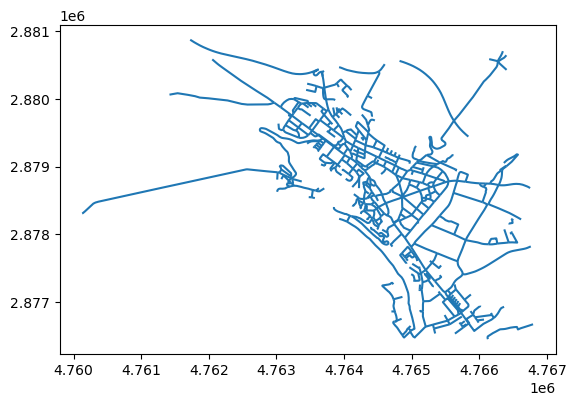

In [16]:
streets.plot()

## Generated data

### Tessellation

We can generate a spatial unit using enclosed morphological tessellation, which aims to approximate plots and captures the area that is nearest to each building, bounded by specified enclosures such as streets, rivers, rail networks, etc. Its formal definition is :

> The portion of space that results from growing a morphological tessellation within an enclosure delineated by a series of natural or built barriers identified from the literature on urban form, function and perception.

Morpohological tessellation is a method to divide space into cells based on building footprints and Voronoi tessellation.

More information is available [here](https://www.sciencedirect.com/science/article/pii/S0197397522001382) .

To create the tessellation, first we create the enclosures based on the street network only. We use an adaptive limit to bound the enclosures, based on the distances to surrounding buildings. The aim is to avoid boundary effects at the edges of the study area. Tessellation cells with a negative index represent empty space with no associated buildings. The are still used in the analysis, to preserve contiguity and neighbourhood information.

In [38]:
idxs = (
    pd.DataFrame(shapely.get_coordinates(buildings.representative_point()))
    .drop_duplicates()
    .index
)

limit = momepy.buffered_limit(buildings.loc[idxs], "adaptive")

enclosures = momepy.enclosures(streets, limit=limit, clip=True)

<Axes: >

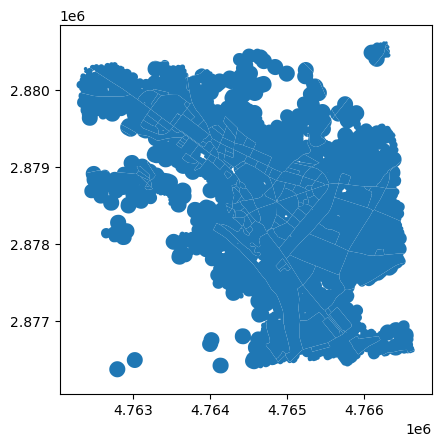

In [39]:
enclosures.plot()

In [40]:
tessellation = momepy.enclosed_tessellation(buildings, enclosures)

In [41]:
tessellation.shape, buildings.shape

((6004, 2), (5982, 7))

OpenStreetMap data are often problematic due to low quality of some polygons. We get a mismatch between the length of buildings and the length of polygons. Therefore, we carry out some ETC post processing:
1. We drop all buildings that collapse into multiple parts during the processing
2. We redo the tessellation
3. We process the tessellation geometries by combining split ETCs and droping any empty space belonging to a particular building 

In [ ]:
collapsed, _ = momepy.verify_tessellation(tessellation, buildings)

In [48]:
buildings = buildings.drop(collapsed).reset_index()

idxs = (
    pd.DataFrame(shapely.get_coordinates(buildings.representative_point()))
    .drop_duplicates()
    .index
)
limit = momepy.buffered_limit(buildings.loc[idxs], "adaptive")
enclosures = momepy.enclosures(streets, limit=limit, clip=True)

tessellation = momepy.enclosed_tessellation(buildings, enclosures)

In [49]:
def postprocess_tessellation(tessellation):
    # deal with split buildings
    tessellation = tessellation.dissolve(by=tessellation.index.values)

    # drop empty spaces with no buildings and a positive index,
    # leave negatives in the geodataframe
    tessellation = tessellation.explode()
    inp, res = buildings.geometry.centroid.sindex.query(tessellation.geometry)
    to_keep = np.append(
        np.unique(inp), np.where(tessellation.index.values < 0)[0]
    )
    tessellation = tessellation.iloc[to_keep]

    ### drop any remaining duplicates
    ## sometimes -1s have multiple tesselation cells
    tessellation = tessellation[~tessellation.index.duplicated()].sort_index()
    return tessellation

In [50]:
tessellation = postprocess_tessellation(tessellation)

In [51]:
tessellation[tessellation.index > -1].shape[0], buildings.shape[0]

(5979, 5979)

### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [52]:
buildings["street_index"] = momepy.get_nearest_street(
    buildings, streets, max_distance=50
)
buildings

index                                           geometry  street_index  \
0         0  POLYGON ((4762801.739 2876377.881, 4762797.198...           NaN   
1         1  POLYGON ((4763024.422 2876493.103, 4763027.968...           NaN   
2         2  POLYGON ((4762755.132 2878092.972, 4762775.653...           NaN   
3         3  POLYGON ((4762884.635 2878089.914, 4762884.394...           NaN   
4         4  POLYGON ((4762659.137 2878144.437, 4762656.371...           NaN   
...     ...                                                ...           ...   
5974   5977  POLYGON ((4766262.592 2880607.059, 4766259.521...         276.0   
5975   5978  POLYGON ((4766282.822 2880594.402, 4766289.062...         276.0   
5976   5979  POLYGON ((4766265.541 2880618.888, 4766261.781...         276.0   
5977   5980  POLYGON ((4766285.856 2880612.455, 4766283.117...         276.0   
5978   5981  POLYGON ((4766294.518 2880626.341, 4766291.772...         276.0   

      building_area       eri  elongation  shared_walls  neighbor_distance  
0         40.560033  1.000054    0.804733      0.000000                NaN  
1         27.110189  0.958965    0.846259      0.000000                NaN  
2         68.485690  0.999511    0.162629      0.000000          82.200240  
3         42.506564  1.000249    0.362430      0.000000          99.124918  
4         54.301096  0.904398    0.741431      0.000000          99.808704  
...             ...       ...         ...           ...                ...  
5974      31.525324  1.000814    0.408839      0.000000          12.320438  
5975     119.058330  1.001668    0.879957      0.393528           3.953323  
5976      39.406272  0.999647    0.764271      0.000000          10.213189  
5977     107.054925  0.916065    0.939147      0.385247           4.159255  
5978     103.432031  1.000084    0.958978      0.254522           0.000000  

[5979 rows x 8 columns]

Aattach the network index to the tessellation as well.

In [53]:
tessellation["street_index"] = buildings["street_index"]

## Measure

Measure individual morphometric characters. For details see the User Guide and the API reference.

### Dimensions

In [54]:
buildings["building_area"] = buildings.area
tessellation["tess_area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [55]:
buildings["eri"] = momepy.equivalent_rectangular_index(buildings)
buildings["elongation"] = momepy.elongation(buildings)
tessellation["convexity"] = momepy.convexity(tessellation)
streets["linearity"] = momepy.linearity(streets)

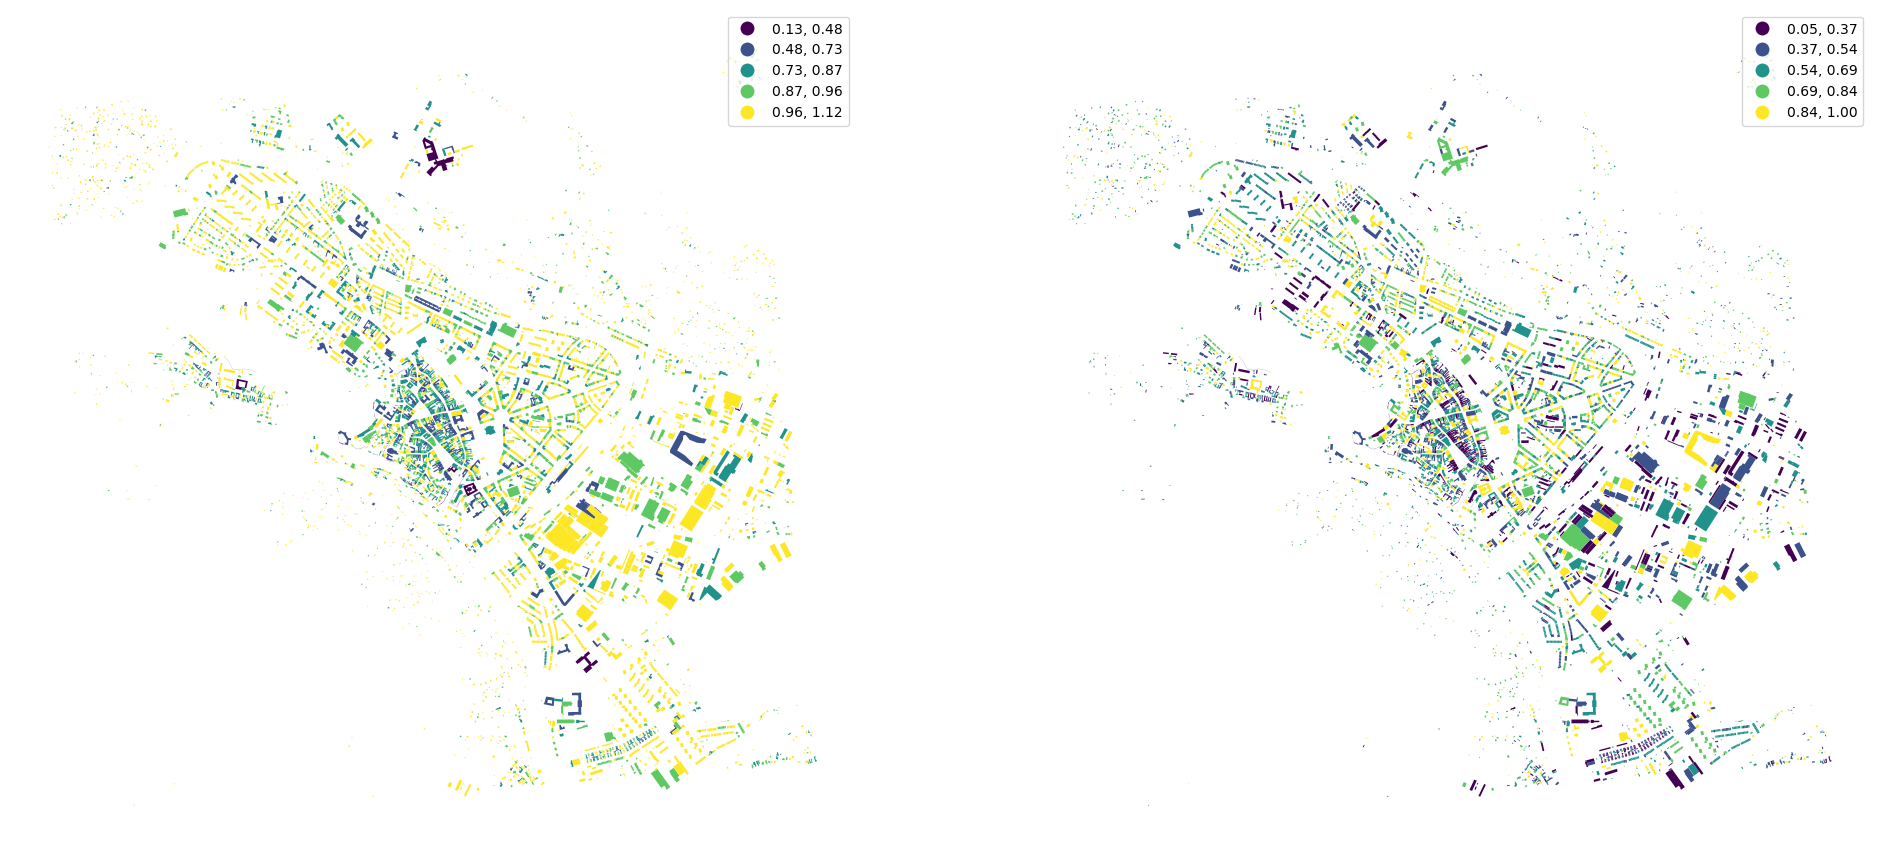

In [162]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

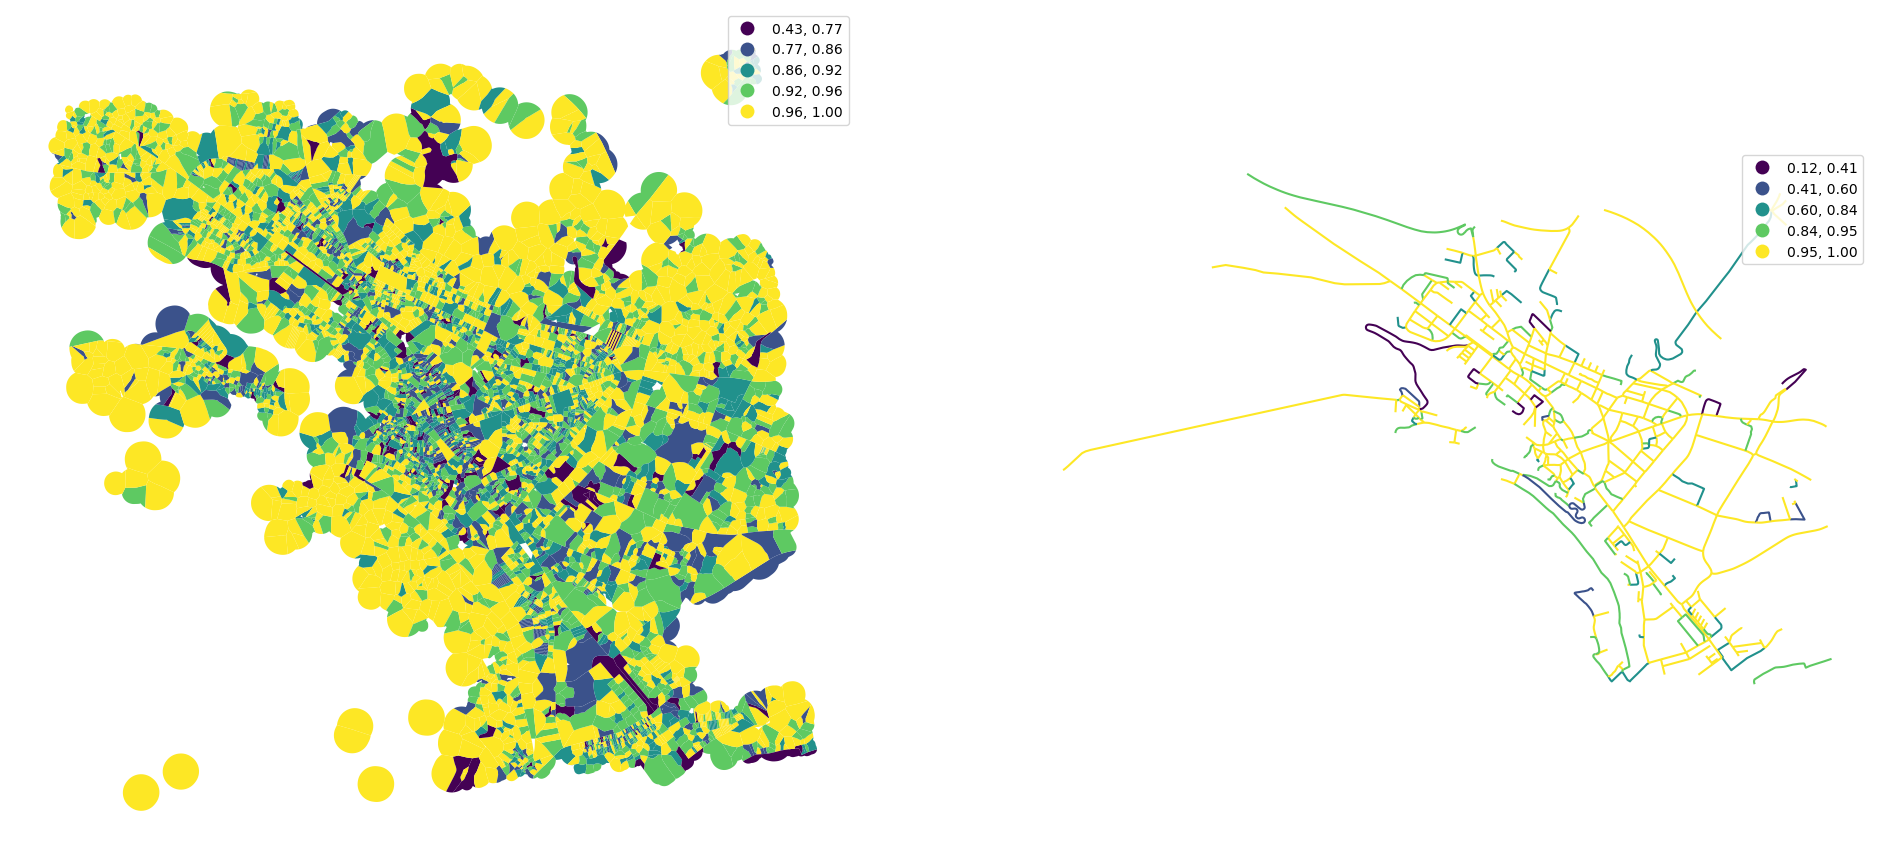

In [163]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

### Spatial distribution

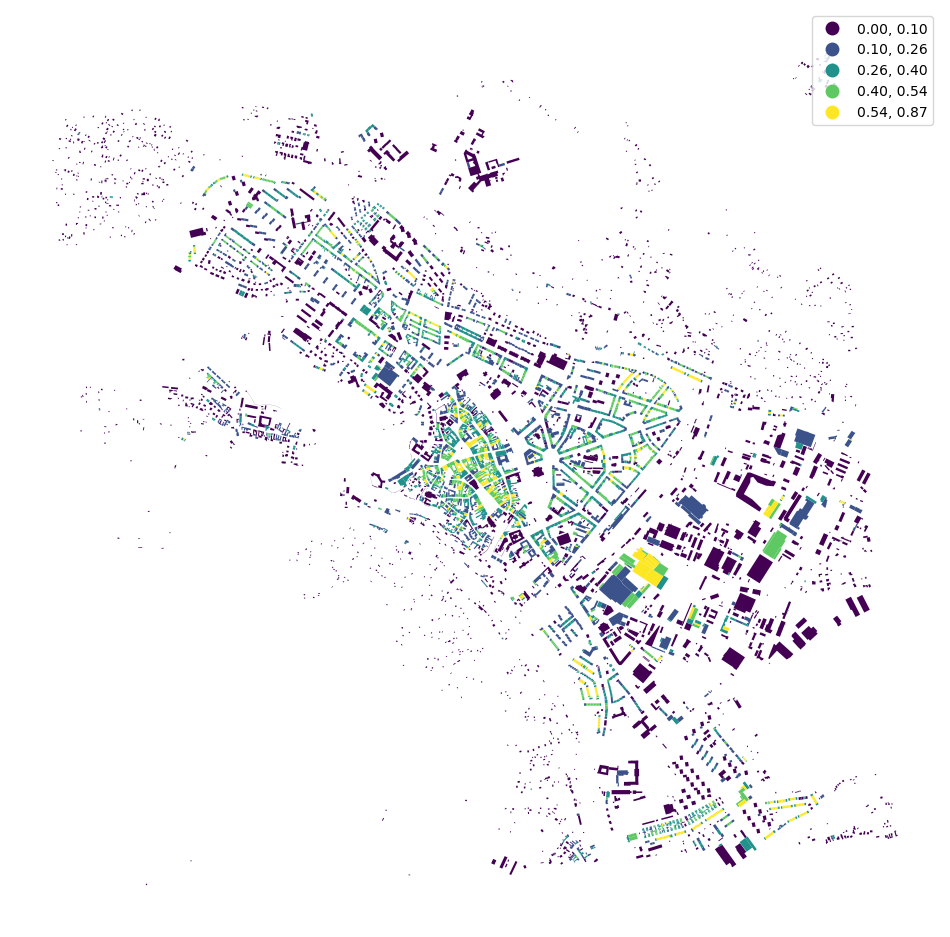

In [58]:
buildings["shared_walls"] = momepy.shared_walls(buildings) / buildings.length
buildings.plot(
    "shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True
).set_axis_off()

Generate spatial graph using `libpysal`.

In [59]:
queen_1 = libpysal.graph.Graph.build_contiguity(tessellation, rook=False)

In [60]:
queen_1

<Graph of 6002 nodes and 30664 nonzero edges indexed by
 [-23, -22, -21, -20, -19, ...]>

Due to floating point errors and data quality there are coverage issues with the polygons. Buildings that should have shared walls overlap .001 cm or overlap only at the corners, or have a miniscule distance between them, for example. The same is true for tessellation cells. To account for this we can use fuzzy contiguity when building a graph of spatial relationships.

In [61]:
queen_1 = libpysal.graph.Graph.build_fuzzy_contiguity(tessellation, buffer=0.5)
queen_1

<Graph of 6002 nodes and 36070 nonzero edges indexed by
 [-23, -22, -21, -20, -19, ...]>

In [62]:
tessellation["neighbors"] = momepy.neighbors(
    tessellation, queen_1, weighted=True
)
tessellation["covered_area"] = queen_1.describe(tessellation.area)["sum"]

In [63]:
# limit graph only to buildings
buildings["neighbor_distance"] = momepy.neighbor_distance(
    buildings, queen_1.subgraph(queen_1.unique_ids[queen_1.unique_ids > -1])
)

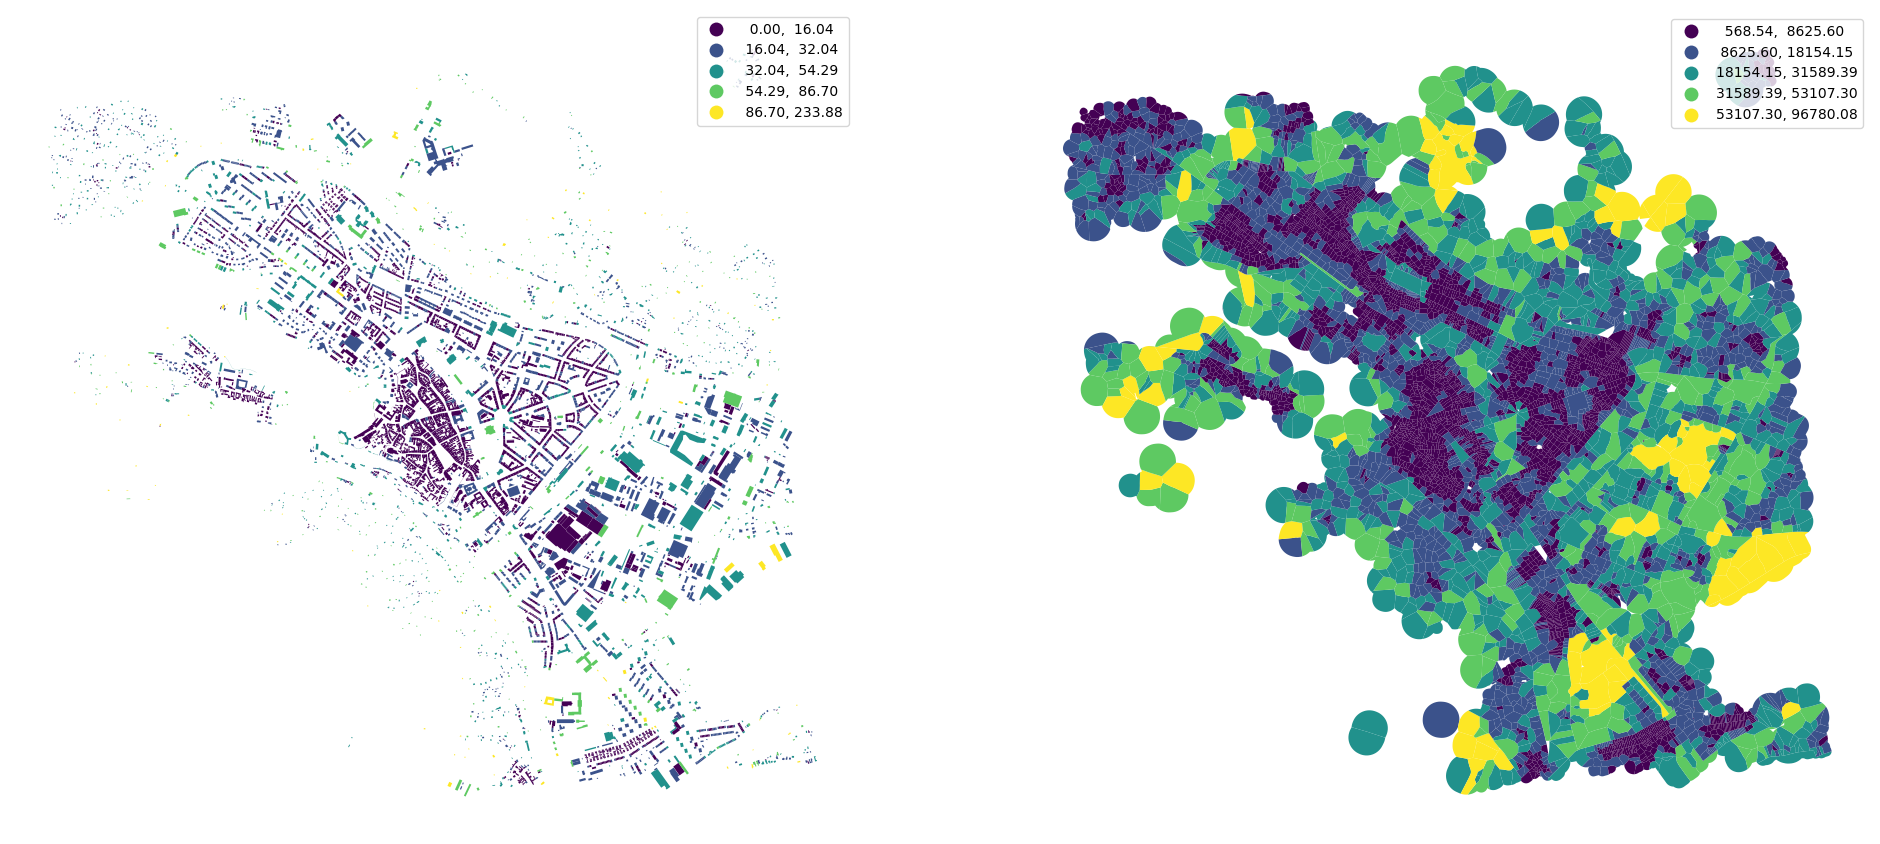

In [161]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot(
    "neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True
)
tessellation.plot(
    "covered_area", ax=ax[1], scheme="natural_breaks", legend=True
)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [65]:
# here we have to get a higher order graph then subset,
# in order to preserve contiguity infromation across the empty space
queen_3 = queen_1.higher_order(3)

buildings["interbuilding_distance"] = momepy.mean_interbuilding_distance(
    buildings,
    queen_1.subgraph(queen_1.unique_ids[queen_1.unique_ids > -1]),
    queen_3.subgraph(queen_3.unique_ids[queen_3.unique_ids > -1]),
)

/home/krasen/micromamba/envs/momepy_dev/lib/python3.13/site-packages/momepy/functional/_distribution.py:375: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances[i] = sub_matrix.sum() / sub_matrix.nnz


In [66]:
buildings_q1 = libpysal.graph.Graph.build_contiguity(buildings, rook=False)
buildings["adjacency"] = momepy.building_adjacency(
    buildings_q1, queen_3.subgraph(queen_3.unique_ids[queen_3.unique_ids > -1])
)

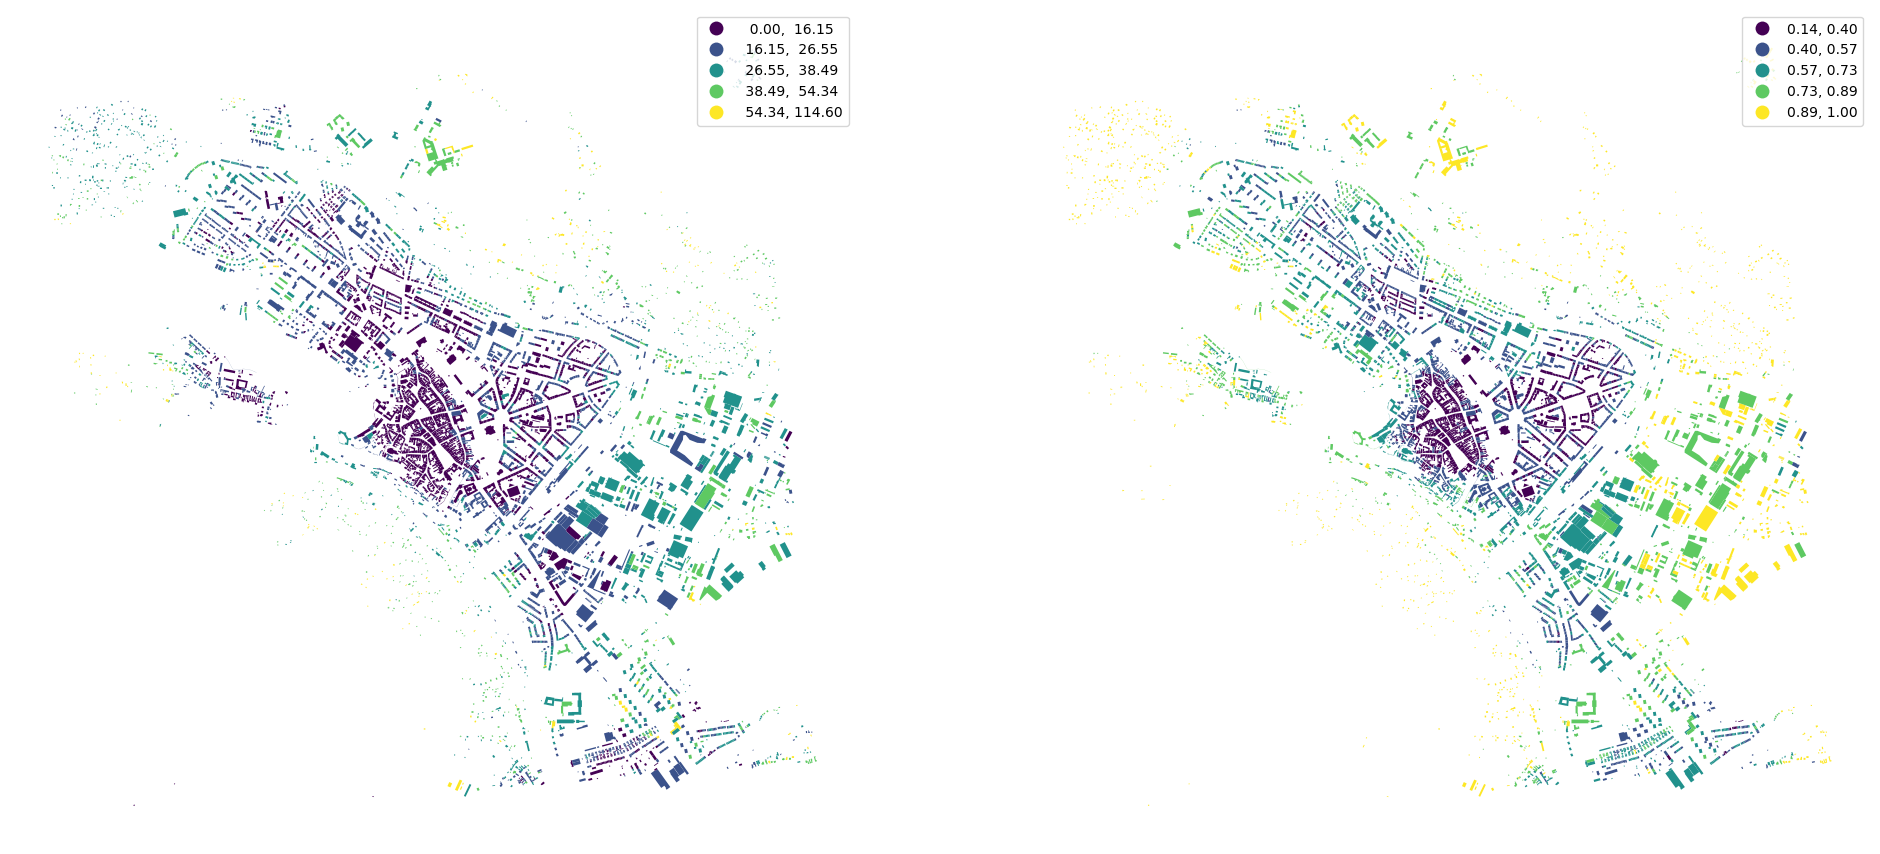

In [160]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot(
    "interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True
)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [68]:
profile = momepy.street_profile(streets, buildings)
streets[profile.columns] = profile

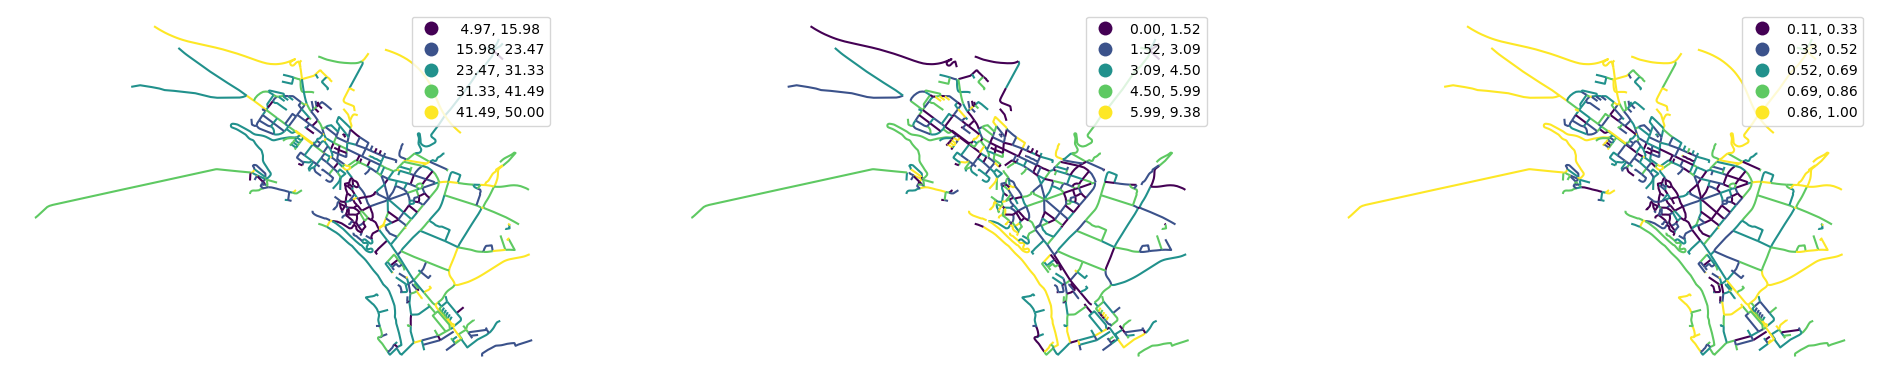

In [159]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

### Intensity

In [158]:
tessellation["car"] = buildings.area / tessellation.area
tessellation.plot(
    "car", figsize=(12, 12), vmin=0, vmax=1, legend=True
).set_axis_off()

### Connectivity

In [71]:
graph = momepy.gdf_to_nx(streets)
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")
nodes, edges = momepy.nx_to_gdf(graph)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [157]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot(
    "degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1
)
nodes.plot(
    "closeness",
    ax=ax[1],
    scheme="natural_breaks",
    legend=True,
    markersize=1,
    legend_kwds={"fmt": "{:.6f}"},
)
nodes.plot(
    "meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1
)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [73]:
buildings["edge_index"] = momepy.get_nearest_street(buildings, edges)
buildings["node_index"] = momepy.get_nearest_node(
    buildings, nodes, edges, buildings["edge_index"]
)

Link all data together (to tessellation cells or buildings).

In [74]:
tessellation.head()

enclosure_index                                           geometry  \
-23                9  POLYGON ((4764292.512 2878953.638, 4764288.161...   
-22               36  POLYGON ((4764482.709 2879050.797, 4764478.706...   
-21               44  POLYGON ((4762842.758 2879557.066, 4762845.756...   
-20               46  POLYGON ((4762838.183 2879491.001, 4762855.576...   
-19               47  POLYGON ((4763179.469 2879162.798, 4763183.309...   

     street_index     tess_area  convexity  neighbors  covered_area  car  
-23           NaN   3502.524352   0.716060   0.021288  29052.443584  NaN  
-22           NaN   5833.528545   0.865280   0.039650  26932.482616  NaN  
-21           NaN  14441.623153   0.947359   0.007033  23969.468979  NaN  
-20           NaN   3728.027359   0.999437   0.002870  14441.623153  NaN  
-19           NaN     68.042585   1.000000   0.014716  14265.312489  NaN

In [75]:
buildings.head()

index                                           geometry  street_index  \
0      0  POLYGON ((4762801.739 2876377.881, 4762797.198...           NaN   
1      1  POLYGON ((4763024.422 2876493.103, 4763027.968...           NaN   
2      2  POLYGON ((4762755.132 2878092.972, 4762775.653...           NaN   
3      3  POLYGON ((4762884.635 2878089.914, 4762884.394...           NaN   
4      4  POLYGON ((4762659.137 2878144.437, 4762656.371...           NaN   

   building_area       eri  elongation  shared_walls  neighbor_distance  \
0      40.560033  1.000054    0.804733           0.0                NaN   
1      27.110189  0.958965    0.846259           0.0                NaN   
2      68.485690  0.999511    0.162629           0.0          82.200240   
3      42.506564  1.000249    0.362430           0.0          99.124918   
4      54.301096  0.904398    0.741431           0.0          99.808704   

   interbuilding_distance  adjacency  edge_index  node_index  
0                     0.0        1.0       220.0       102.0  
1                     0.0        1.0       527.0       310.0  
2                     NaN        1.0       611.0       417.0  
3                     NaN        1.0       611.0       417.0  
4                     NaN        1.0       611.0       417.0

In [76]:
tessellation[buildings.columns.drop(["geometry", "street_index"])] = (
    buildings.drop(columns=["geometry", "street_index"])
)
merged = tessellation.merge(
    edges.drop(columns="geometry"),
    left_on="edge_index",
    right_index=True,
    how="left",
)
merged = merged.merge(
    nodes.drop(columns="geometry"),
    left_on="node_index",
    right_index=True,
    how="left",
)

In [77]:
merged.columns

Index(['enclosure_index', 'geometry', 'street_index', 'tess_area', 'convexity',
       'neighbors', 'covered_area', 'car', 'index', 'building_area', 'eri',
       'elongation', 'shared_walls', 'neighbor_distance',
       'interbuilding_distance', 'adjacency', 'edge_index', 'node_index',
       '_status', 'id', 'class', 'length', 'linearity', 'width', 'openness',
       'width_deviation', 'mm_len', 'node_start', 'node_end', 'x', 'y',
       'degree', 'closeness', 'meshedness', 'nodeID'],
      dtype='object')

In [105]:
attr_columns = merged.columns.drop(
    [
        "index",
        "enclosure_index",
        "street_index",
        "node_index",
        "edge_index",
        "nodeID",
        "mm_len",
        "node_start",
        "node_end",
        "geometry",
        "x",
        "y",
        "id",
        "class",
        "_status",
    ]
)

In [106]:
merged[attr_columns]

tess_area  convexity  neighbors  covered_area       car  \
-23     3502.524352   0.716060   0.021288  29052.443584       NaN   
-22     5833.528545   0.865280   0.039650  26932.482616       NaN   
-21    14441.623153   0.947359   0.007033  23969.468979       NaN   
-20     3728.027359   0.999437   0.002870  14441.623153       NaN   
-19       68.042585   1.000000   0.014716  14265.312489       NaN   
...             ...        ...        ...           ...       ...   
 5974    564.756143   0.983123   0.030365   4082.656019  0.055821   
 5975    287.798675   0.929578   0.055302   2677.986446  0.413686   
 5976    668.064335   0.954078   0.038417   1798.788178  0.058986   
 5977    317.072718   0.882149   0.047230   2418.418564  0.337635   
 5978    398.866802   0.977339   0.024382   1380.761470  0.259315   

       building_area       eri  elongation  shared_walls  neighbor_distance  \
-23              NaN       NaN         NaN           NaN                NaN   
-22              NaN       NaN         NaN           NaN                NaN   
-21              NaN       NaN         NaN           NaN                NaN   
-20              NaN       NaN         NaN           NaN                NaN   
-19              NaN       NaN         NaN           NaN                NaN   
...              ...       ...         ...           ...                ...   
 5974      31.525324  1.000814    0.408839      0.000000          12.320438   
 5975     119.058330  1.001668    0.879957      0.393528           3.953323   
 5976      39.406272  0.999647    0.764271      0.000000          10.213189   
 5977     107.054925  0.916065    0.939147      0.385247           4.159255   
 5978     103.432031  1.000084    0.958978      0.254522           0.000000   

       interbuilding_distance  adjacency      length  linearity      width  \
-23                       NaN        NaN         NaN        NaN        NaN   
-22                       NaN        NaN         NaN        NaN        NaN   
-21                       NaN        NaN         NaN        NaN        NaN   
-20                       NaN        NaN         NaN        NaN        NaN   
-19                       NaN        NaN         NaN        NaN        NaN   
...                       ...        ...         ...        ...        ...   
 5974               34.927472   0.909091  165.859427   0.996184  25.098461   
 5975               18.600174   1.000000  165.859427   0.996184  25.098461   
 5976               20.680381   0.900000  165.859427   0.996184  25.098461   
 5977               25.667594   1.000000  165.859427   0.996184  25.098461   
 5978               26.106975   1.000000  165.859427   0.996184  25.098461   

       openness  width_deviation  degree  closeness  meshedness  
-23         NaN              NaN     NaN        NaN         NaN  
-22         NaN              NaN     NaN        NaN         NaN  
-21         NaN              NaN     NaN        NaN         NaN  
-20         NaN              NaN     NaN        NaN         NaN  
-19         NaN              NaN     NaN        NaN         NaN  
...         ...              ...     ...        ...         ...  
 5974     0.775         3.898415     5.0    0.00005         0.0  
 5975     0.775         3.898415     5.0    0.00005         0.0  
 5976     0.775         3.898415     5.0    0.00005         0.0  
 5977     0.775         3.898415     5.0    0.00005         0.0  
 5978     0.775         3.898415     5.0    0.00005         0.0  

[6002 rows x 20 columns]

## Unsupervised machine learning

## Morphotopes

The first step in the analysis is to group our elements into morphotopes using the `SA3` algorithm. Morphotopes are defined as :

> “the smallest urban locality obtaining distinctive character among their neighbours from their particular combination of constituent morphological elements.”

We do this to create contiguous units which can act as the base of the hierarchical analysis. 

This is also an example of the second way of using spatial relationships - directly embeding them in the algorithm.

In [107]:
from sklearn.preprocessing import StandardScaler
from spopt.region import SA3

In [108]:
attr_columns

Index(['tess_area', 'convexity', 'neighbors', 'covered_area', 'car',
       'building_area', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'length',
       'linearity', 'width', 'openness', 'width_deviation', 'degree',
       'closeness', 'meshedness'],
      dtype='object')

In [109]:
# limit the analysis to only the tessellation cells with buildings in them
# and only to the selected columns
training_data = merged.loc[merged.index > -1, attr_columns]

# standardise data and fill NAs with 0
res = StandardScaler().fit_transform(training_data)
standardised_data = pd.DataFrame(res, columns=attr_columns).fillna(0)

In [141]:
clusterer = SA3(
    standardised_data,
    queen_1.subgraph(queen_1.unique_ids[queen_1.unique_ids > -1]),
    standardised_data.columns,
    min_cluster_size=30,
    extraction="eom",
    linkage="complete",
)
clusterer.solve()
clusterer.labels_.value_counts()

-1     1124
 1      265
 17     257
 19     239
 58     220
 31     200
 6      159
 44     146
 46     135
 14     134
 38     134
 40     127
 12     122
 49     119
 39     107
 36     101
 29     101
 56      98
 16      96
 24      96
 42      89
 25      89
 50      84
 45      80
 43      72
 5       67
 33      66
 18      63
 13      63
 27      63
 7       61
 0       57
 47      56
 22      54
 10      54
 21      53
 32      52
 3       51
 11      47
 9       46
 48      45
 37      44
 34      44
 30      43
 26      42
 4       41
 23      39
 52      38
 54      37
 2       36
 51      35
 28      33
 20      33
 53      33
 41      33
 55      32
 8       31
 15      31
 57      31
 35      31
Name: count, dtype: int64

## Clustering

Now we can use the morphotopes to create a hierarchical typology of urban structure. To do this we use simple dendrogram clustering models.


In [142]:
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

In [143]:
morph_clusters = clusterer.labels_

In [144]:
grouped_data = standardised_data.groupby(morph_clusters).median()
if -1 in grouped_data.index:
    grouped_data = grouped_data.iloc[1:]

In [145]:
linkage_matrix = linkage(grouped_data, method="ward")

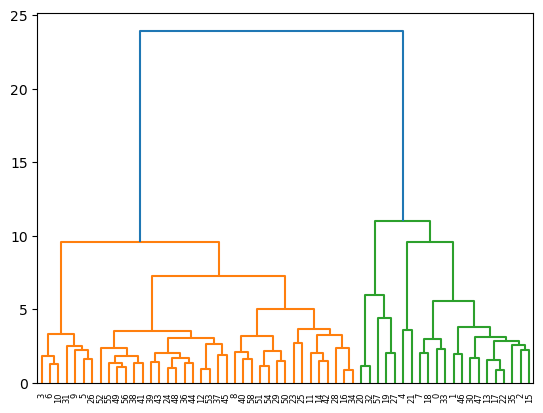

In [146]:
_ = dendrogram(linkage_matrix)

In [152]:
morphotope_labels = fcluster(linkage_matrix, t=5, criterion="distance")
pd.Series(morphotope_labels).value_counts()

2    16
3    15
8    10
1     7
7     4
5     3
6     2
4     2
Name: count, dtype: int64

In [153]:
final_labels = pd.Series(morph_clusters).replace(
    pd.Series(morphotope_labels, index=grouped_data.index).to_dict()
)
final_labels.value_counts()

 2    1300
 3    1206
-1    1124
 8     971
 1     619
 5     333
 7     247
 6      94
 4      85
Name: count, dtype: int64

The SA3 algorithm assigns buildings that are not morphologically similar to another group, or are not numerous enough to form a morphotope to a noise cluster. One way to deal with this noise cluster is to assign each tessellation cell in to its nearest cluster. We do this next.

In [154]:
from sklearn.neighbors import KDTree

cluster_centres = standardised_data.groupby(final_labels).median().iloc[1:]
tree = KDTree(cluster_centres)
dists, idxs = tree.query(standardised_data[final_labels == -1], k=1)
final_labels[final_labels == -1] = idxs[:, 0] + 1

In [155]:
buildings[["geometry"]].explore(
    column=final_labels, categorical=True, legend=True
)

In [156]:
merged[attr_columns].groupby(final_labels).median().T.iloc[
    :,
].style.background_gradient(axis=1)